In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [24]:
def load_ecoli():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data"
    df = pd.read_csv(url, delim_whitespace=True, header=None)
    X = df.iloc[:, 1:-1].values
    y = LabelEncoder().fit_transform(df.iloc[:, -1].values)
    return X, y

X, y = load_ecoli()

In [25]:
# нормализуем данные
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# теперь исключим часть меток из тренировочной выборки
labeled_ratio = 0.8  # доля размеченных данных
n_labeled = int(len(X_train) * labeled_ratio)
X_labeled = X_train[:n_labeled]
y_labeled = y_train[:n_labeled]
X_unlabeled = X_train[n_labeled:]

# проверяем кол-во классов в размеченной выборке
unique_classes = np.unique(y_labeled)
n_classes = len(unique_classes)

In [26]:
# обучим lda на размеченных данных
lda = LDA()
lda.fit(X_labeled, y_labeled)
lda_acc = accuracy_score(y_test, lda.predict(X_test))

# проинициализируем GMM параметрами из lda
gmm = GMM(n_components=n_classes, covariance_type="tied", random_state=42)
gmm.means_init = lda.means_  # средние из lda
gmm.fit(X_labeled)

GaussianMixture(covariance_type='tied',
                means_init=array([[-0.71896277, -0.58058061, -0.17514236, -0.05463584, -0.44489355,
        -0.86267109, -0.48758976],
       [-0.21127227,  0.05002156, -0.05744669, -0.05463584,  0.36966157,
         1.17727996,  1.04193808],
       [ 1.15743388, -0.20279012,  5.70964097,  9.12418469, -0.36851195,
         0.67224354,  0.33605121],
       [ 1.23461656,  0.06759671, -0.17514236, -0.054635...
       [ 1.14671407, -0.22532236,  0.07005694, -0.05463584,  0.34415558,
         1.11902438,  1.12315971],
       [ 0.68732121,  1.35193415,  0.35983794, -0.05463584,  1.76298085,
        -0.22870296, -0.81608   ],
       [ 0.97734097,  0.03379835,  5.70964097, -0.05463584,  0.73629322,
         0.3937308 , -1.28997547],
       [ 0.79958692,  1.58135328, -0.17514236, -0.05463584, -0.53342675,
        -0.16259135, -0.64507184]]),
                n_components=8, random_state=42)

In [27]:
# em
for _ in range(10):
    # вычисляем вероятности для неразмеченных данных
    unlabeled_probs = gmm.predict_proba(X_unlabeled)

    # присваиваем метки, только если уверенность >= 0.9
    y_unlabeled = np.argmax(unlabeled_probs, axis=1)
    confident_indices = np.max(unlabeled_probs, axis=1) >= 0.9
    X_confident = X_unlabeled[confident_indices]
    y_confident = y_unlabeled[confident_indices]

    # переобучаем gmm
    X_combined = np.vstack((X_labeled, X_confident))
    y_combined = np.hstack((y_labeled, y_confident))
    gmm.fit(X_combined)

In [28]:
# Переобучаем lda на дополненных данных
lda_em = LDA()
lda_em.fit(X_combined, y_combined)
lda_em_acc = accuracy_score(y_test, lda_em.predict(X_test))  # точность lda после em

In [29]:
results = pd.DataFrame({
    "Method": ["LDA (labeled only)", "LDA + GMM (with EM)"],
    "Accuracy": [lda_acc, lda_em_acc]
})
print(results)

                Method  Accuracy
0   LDA (labeled only)  0.867647
1  LDA + GMM (with EM)  0.897059


Вспомним, что в задании 3 для этого датасета получали результат 0.808824 для rLDA, то есть результат улучшился

Дополнительно: посмотрите, как меняется качество, когда доля неразмеченных данных падает

In [47]:
import matplotlib.pyplot as plt

In [48]:
labeled_ratios = np.linspace(0.5, 0.9, 5)  # доли размеченных данных
lda_accuracies = []
lda_em_accuracies = []

In [49]:
for labeled_ratio in labeled_ratios:
    n_labeled = int(len(X_train) * labeled_ratio)
    X_labeled = X_train[:n_labeled]
    y_labeled = y_train[:n_labeled]
    X_unlabeled = X_train[n_labeled:]

    unique_classes = np.unique(y_labeled)
    n_classes = len(unique_classes)

    lda = LDA()
    lda.fit(X_labeled, y_labeled)
    lda_acc = accuracy_score(y_test, lda.predict(X_test))
    lda_accuracies.append(lda_acc)

    gmm = GMM(n_components=n_classes, covariance_type="tied", random_state=42)
    gmm.means_init = lda.means_
    gmm.fit(X_labeled)

    # em
    for _ in range(10):
        unlabeled_probs = gmm.predict_proba(X_unlabeled)
        y_unlabeled = np.argmax(unlabeled_probs, axis=1)
        confident_indices = np.max(unlabeled_probs, axis=1) >= 0.9
        X_confident = X_unlabeled[confident_indices]
        y_confident = y_unlabeled[confident_indices]

        X_combined = np.vstack((X_labeled, X_confident))
        y_combined = np.hstack((y_labeled, y_confident))
        gmm.fit(X_combined)

    lda_em = LDA()
    lda_em.fit(X_combined, y_combined)
    lda_em_acc = accuracy_score(y_test, lda_em.predict(X_test))
    lda_em_accuracies.append(lda_em_acc)

In [51]:
results_table = pd.DataFrame({
    "Labeled Ratio": labeled_ratios,
    "LDA (labeled only)": lda_accuracies,
    "LDA + GMM (with EM)": lda_em_accuracies
})

print(results_table)

   Labeled Ratio  LDA (labeled only)  LDA + GMM (with EM)
0            0.5            0.168317             0.673267
1            0.6            0.108911             0.772277
2            0.7            0.435644             0.811881
3            0.8            0.871287             0.881188
4            0.9            0.871287             0.881188


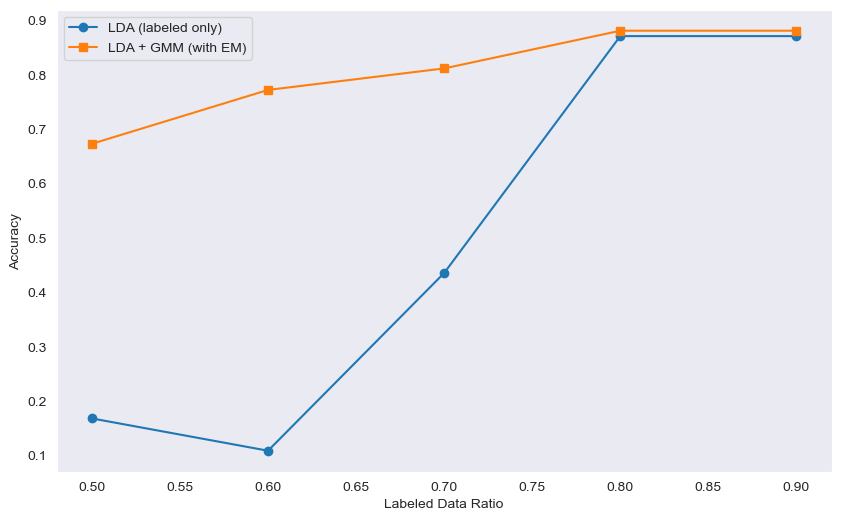

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(labeled_ratios, lda_accuracies, marker='o', label='LDA (labeled only)')
plt.plot(labeled_ratios, lda_em_accuracies, marker='s', label='LDA + GMM (with EM)')
plt.xlabel('Labeled Data Ratio')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()